In [102]:
import os

import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [93]:
all_files = []

data_dir = os.path.join("..", "data")
lindt_data_dir = os.path.join(data_dir, "ExtractiondeLINDT")
subfolders = [f.path for f in os.scandir(lindt_data_dir) if f.is_dir()]
for folder in subfolders:
    current_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    all_files.extend(current_files)
print(all_files)

['..\\data\\ExtractiondeLINDT\\01\\sem01.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem02.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem03.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem04.xlsx', '..\\data\\ExtractiondeLINDT\\01\\sem05.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem06.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem07.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem08.xlsx', '..\\data\\ExtractiondeLINDT\\02\\sem09.xlsx', '..\\data\\ExtractiondeLINDT\\03\\sem10.xlsx', '..\\data\\ExtractiondeLINDT\\04\\01avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\1avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\2avril23.xlsx', '..\\data\\ExtractiondeLINDT\\04\\3avril23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\1mail23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\2mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\3mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\4mai23.xlsx', '..\\data\\ExtractiondeLINDT\\05\\5mai23.xlsx', '..\\data\\ExtractiondeLINDT\\06\\1Juin23.xlsx', '..\\data\\ExtractiondeLINDT\\06\\2Jui

In [94]:
df = None
for path in all_files:
    current_df = pd.read_excel(path, header=17)
    current_df['Month'] = path.split("\\")[-2]
    df = pd.concat([df, current_df], ignore_index=True)
df.head()

,Code Secteur,Libellé Secteur,Code Rayon,Libellé Rayon,Code Groupe de Famille,Libellé Groupe de Famille,Code Famille,Libellé Famille,Code Sous-Famille,Libellé Sous-Famille,...,PV Mag,Type PV Mag,Indicateur PV Mag,TVA en %,Quantité vendue *,Type Qté,Stock en quantité,Unnamed: 30,Unnamed: 31,Month
0,1,PGC,14,EPICERIE,140,PDTS POUR PETITS DEJEUNERS,1404,PATES A TARTINER,0,PATE A TARTINER,...,4.99,PVC,E,0.055,NaN,UVC,0,NaN,1,01
1,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,3.25,PVC,E,0.055,NaN,UVC,17,NaN,1,01
2,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,2.19,PVC,E,0.055,NaN,UVC,0,NaN,1,01
3,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,2.58,PVC,E,0.055,NaN,UVC,0,NaN,1,01
4,1,PGC,14,EPICERIE,142,CONFISERIE,1420,TABLETTES DE CHOCOLAT,0,DESSERT,...,5.69,PVC,E,0.055,NaN,UVC,24,NaN,2,01


## Remove Unnecessary Columns

In [95]:
df = df.drop(df.columns[:15], axis=1)
columns_to_keep = [col for col in df.columns if "Unnamed" not in col]
df = df[columns_to_keep]
columns_to_drop = ["Article Libellé Court", "Type PA", "SRP", "Indicateur PVC", "Type PV Mag", "Indicateur PV Mag", "Type Qté"] # specific columns which we don't need 
df = df.drop(columns=columns_to_drop)
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,Month
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,NaN,0,01
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,NaN,17,01
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,NaN,0,01
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,NaN,0,01
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,NaN,24,01


## Clean the values

In [97]:
df = df[~df["PAHT"].isna()]
df = df[~df["PVC"].isna()]
df["Quantité vendue *"] = df["Quantité vendue *"].fillna(0)
df.reset_index(drop=True, inplace=True)
df

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,Month
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,0.0,0,01
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,0.0,17,01
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,0.0,0,01
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,0.0,0,01
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,0.0,24,01
...,...,...,...,...,...,...,...,...,...
7002,3046920012089,137G SACH OURS TEDDY LAIT,4.91,5.69,5.69,0.055,0.0,0,12
7003,4000539669804,LINDT LAPIN LAIT NOISETTE,3.38,3.85,3.85,0.200,0.0,102,12
7004,4000539697807,LAPIN OR LAIT FLEURS 100G,3.19,2.30,2.30,0.200,0.0,0,12
7005,4000539647000,LINDT POUSSIN LAIT MOULAG,2.76,3.70,3.49,0.200,0.0,0,12


## Custom calculations

In [98]:
df["Buying Cost without Taxes"] = round(df["PAHT"] * df["Quantité vendue *"], 2)
df["Buying Cost with Taxes"] = round(df["PAHT"] * df["Quantité vendue *"] * (1 + df["TVA en %"]), 2)
df["Revenue"] = round(df["PVC"] * df["Quantité vendue *"], 2)
df["Profit"] = df["Revenue"] - df["Buying Cost with Taxes"]
df.head()

,EAN,Article Libellé Long,PAHT,PVC,PV Mag,TVA en %,Quantité vendue *,Stock en quantité,Month,Buying Cost without Taxes,Buying Cost with Taxes,Revenue,Profit
0,8013108699504,200G PATE A TARTINER 25%,4.31,4.99,4.99,0.055,0.0,0,01,0.0,0.0,0.0,0.0
1,3046920021043,200G DESSERT NR 70% INTEN,2.50,3.25,3.25,0.055,0.0,17,01,0.0,0.0,0.0,0.0
2,3046920026666,DESSERT NR EXTRA FONDANT,1.92,2.19,2.19,0.055,0.0,0,01,0.0,0.0,0.0,0.0
3,3046920026826,A CUISINER 70% CACAO 180G,1.79,2.58,2.58,0.055,0.0,0,01,0.0,0.0,0.0,0.0
4,3046920021463,200GX2 DESSERT NR 70% INT,4.79,5.69,5.69,0.055,0.0,24,01,0.0,0.0,0.0,0.0


## Data Analysis

### Total Revenues

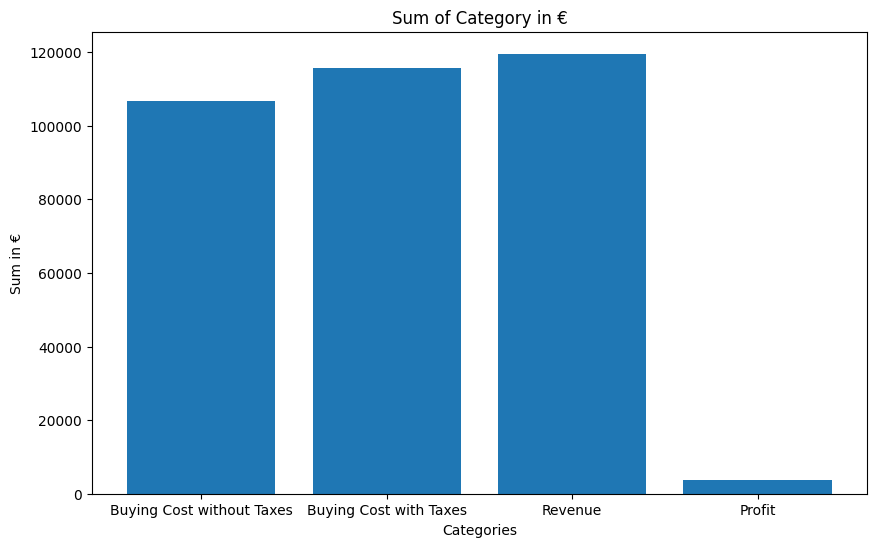

In [109]:
columns = ["Buying Cost without Taxes", "Buying Cost with Taxes", "Revenue", "Profit"]
sum_values = []

for column in columns:
    sum_values.append(round(df[column].sum(),2))

plt.figure(figsize=(10,6))
plt.bar(columns, sum_values)
plt.xlabel("Categories")
plt.ylabel("Sum in €")
plt.title("Sum of Category in €")
plt.show()

### Revenues by Month

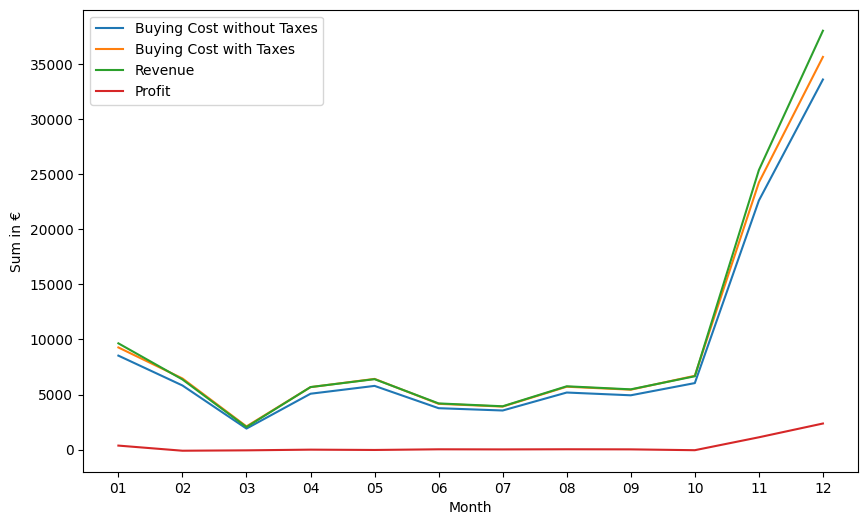

In [117]:
sum_values_by_month = []
for column in columns:
    current_values = df.groupby("Month")[column].sum()
    sum_values_by_month.append(current_values.round(2).tolist())
months = df['Month'].unique().tolist()

plt.figure(figsize=(10,6))
for i, values in enumerate(sum_values_by_month, start=0):
    plt.plot(months, values, label=columns[i])
plt.xlabel("Month")
plt.ylabel("Sum in €")
plt.legend()
plt.show()

### Revenues by Product (best Products)

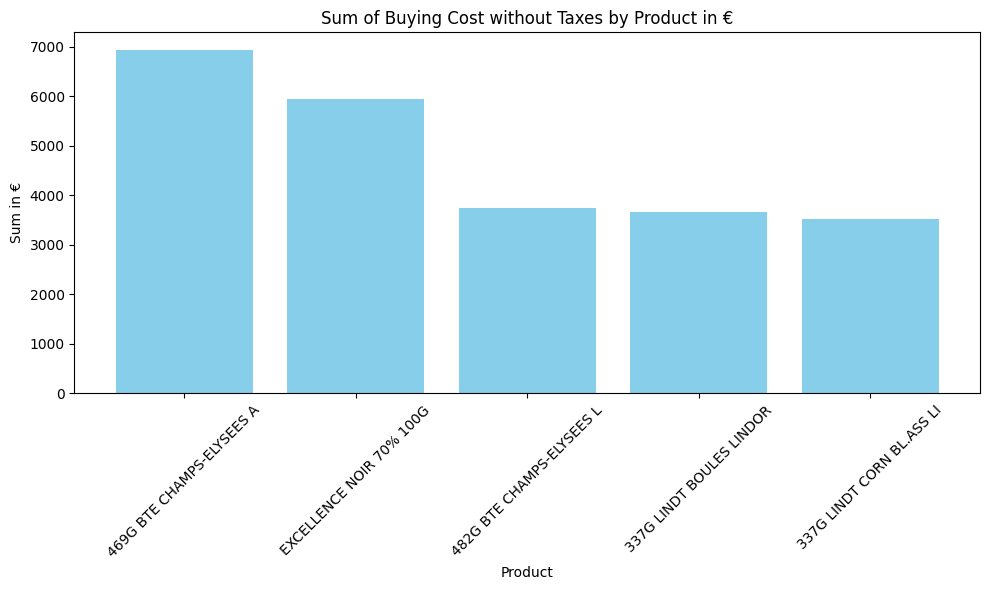

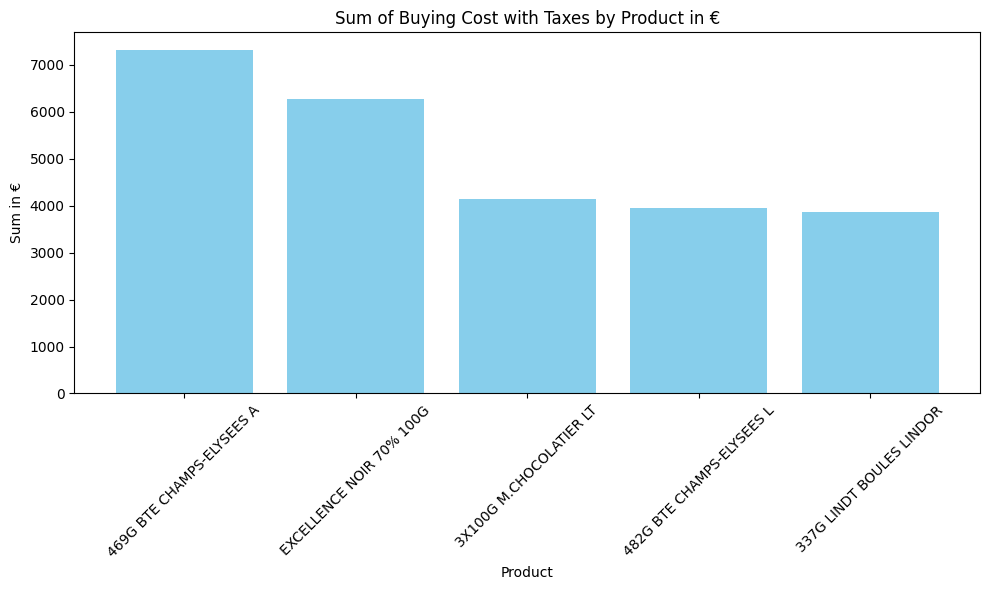

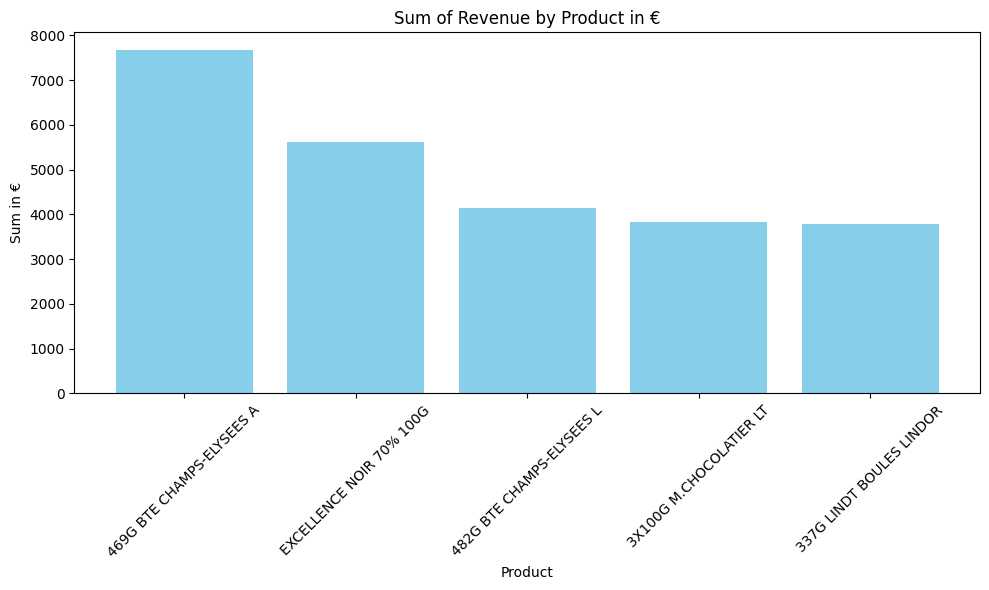

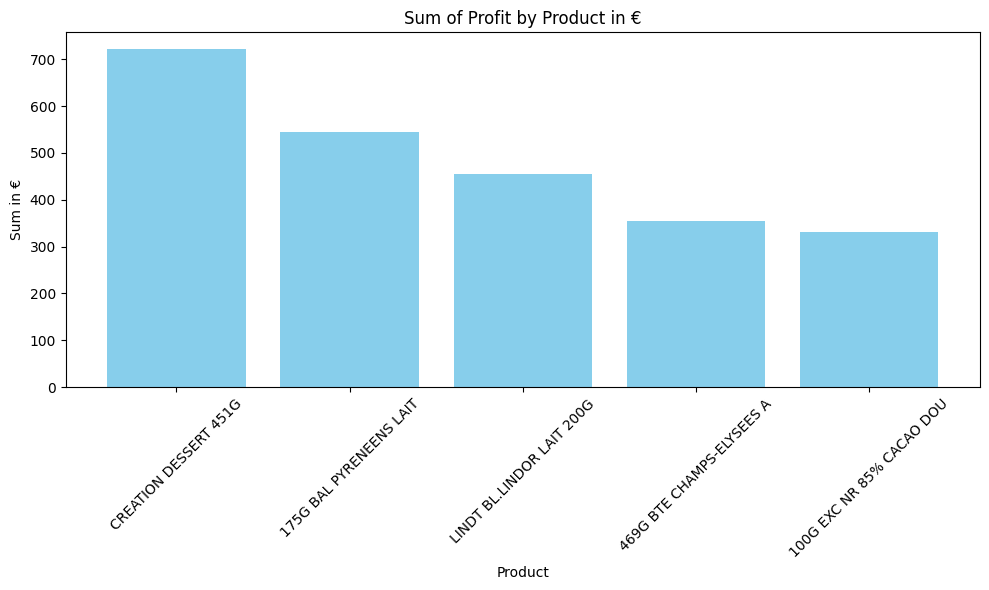

In [130]:
sum_values_by_product = []
for column in columns:
    current_values = df.groupby("Article Libellé Long")[column].sum()
    sum_values_by_product.append(current_values.round(2))
for i, series in enumerate(sum_values_by_product):
    top_5_index = series.nlargest(5).index
    top_5_rows = series.loc[top_5_index]
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(top_5_rows.index, top_5_rows.values, color='skyblue')  # Replace 'column_name' and 'value_column' with your column names
    plt.xlabel('Product')  # Set the label for the x-axis
    plt.ylabel('Sum in €')  # Set the label for the y-axis
    plt.title(f'Sum of {columns[i]} by Product in €')  # Set the title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()